In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers, regularizers, models, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle, randint
import numpy as np
import future
from keras.applications import VGG16
from PIL import Image

import matplotlib.pyplot as plt

from os import listdir, mkdir
from os.path import join, isfile, isdir, exists, expanduser
from shutil import rmtree, copyfile
import file_utils
from file_utils import make_dir_helper, delete_dir_helper, is_jpeg
from keras.models import load_model, model_from_json

In [8]:
def compile_model(model):
    
    model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])
    model.summary()

In [9]:
def get_class_names(base_dir):
    return [dname for dname in listdir(base_dir) if isdir(join(base_dir, dname))]

In [10]:
#project_dir_name = join('Esri Project')
project_dir_name = join('desktop','Esri Project')
original_dataset_dir = join(expanduser('~'), project_dir_name, 'original data 2');
base_dir =  join(expanduser('~'), project_dir_name, 'data');
base_scripts_dir =  join(expanduser('~'), project_dir_name, 'scripts');
model_dir =  join(expanduser('~'),  project_dir_name, 'models');

MODEL_FILE_NAME = 'map_multi_model_9.h5'

CLASSES_TO_CLASSIFY = get_class_names(original_dataset_dir)
print(CLASSES_TO_CLASSIFY)
NO_OF_CLASSES = len(CLASSES_TO_CLASSIFY)

ext = '.jpg'
IMAGE_SIZE = 150
EPOCHS = 30
NO_TRAINING_SAMPLES = 70
BATCH_SIZE = 15
STEPS_PER_EPOCH = 5

train_dir = join(base_dir, 'train')
validation_dir = join(base_dir, 'validation')
test_dir = join(base_dir, 'test')
model_file_path = join(model_dir, MODEL_FILE_NAME)

# Delete the previous data folder and all its contents
delete_dir_helper(base_dir)

make_dir_helper(base_dir)
make_dir_helper(model_dir)

# Make base directories
make_dir_helper(train_dir)
make_dir_helper(validation_dir)
make_dir_helper(test_dir)

for classes in CLASSES_TO_CLASSIFY:
    
    train_class_dir = join(train_dir, classes)
    validation_class_dir = join(validation_dir, classes)
    test_class_dir = join(test_dir, classes)
    
    # Make train sub directories
    make_dir_helper(train_class_dir)
    make_dir_helper(validation_class_dir)
    make_dir_helper(test_class_dir)
    
    
    original_dataset_class_dir = join(original_dataset_dir, classes)
    fnames = [fname for fname in listdir(original_dataset_class_dir) if isfile(join(original_dataset_class_dir,fname)) and is_jpeg(fname)]
    
    shuffle(fnames)
    
    for idx, fname in enumerate(fnames):
        
        src_dir = join(original_dataset_class_dir, fname)
        if idx < 70:
            dst_dir = join(train_class_dir, fname)
            copyfile(src_dir, dst_dir)
        elif 70 <= idx < 100:
            dst_dir = join(validation_class_dir, fname)
            copyfile(src_dir, dst_dir)
            
            dst_dir = join(test_class_dir, fname)
            copyfile(src_dir, dst_dir)

['agricultural', 'beach', 'chaparral', 'denseresidential', 'forest', 'freeway', 'harbor', 'parkinglot', 'storagetanks']


NO saved model with name map_multi_model_9.h5
Found 630 images belonging to 9 classes.
Found 270 images belonging to 9 classes.
data batch: (15, 150, 150, 3)
labels batch: (15, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2313      
Total params: 16,814,409
Trainable params: 2,099,721
Non-trainable params: 14,714,688
________

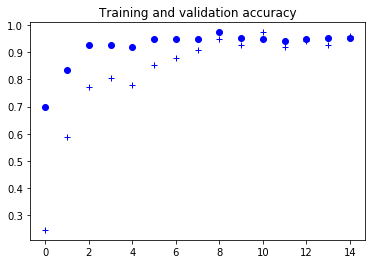

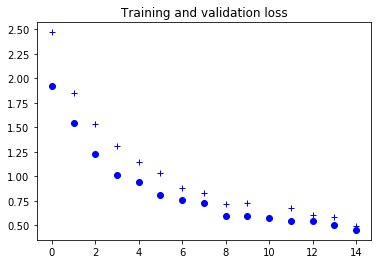

In [11]:
model = None
if exists(model_file_path):
    model = load_model(model_file_path)
    print('Found saved model with name ' + MODEL_FILE_NAME)
    compile_model(model)

else:
    print('NO saved model with name ' + MODEL_FILE_NAME)   
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       vertical_flip=True,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True)  
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            train_dir,  
            target_size=(IMAGE_SIZE, IMAGE_SIZE),  
            batch_size=BATCH_SIZE,
            class_mode='categorical')  

    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

    for idx, (data_batch, labels_batch) in enumerate(train_generator):
        print('data batch:', data_batch.shape)
        print('labels batch:', labels_batch.shape)
        break

    model = models.Sequential()
    conv_base = VGG16(weights='imagenet' ,include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    for layer in conv_base.layers:
        if 'block_5' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False

    
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(NO_OF_CLASSES, activation='softmax'))

    compile_model(model)
    conv_base.summary()

    callbacks = [
        EarlyStopping(monitor='acc', patience=3, mode='auto'),
        ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=model_file_path)
    ]
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks = callbacks,
        validation_steps=10)

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b+')
    plt.plot(epochs, val_acc, 'bo')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'b+')
    plt.plot(epochs, val_loss, 'bo')
    plt.title('Training and validation loss')

    plt.show()

In [12]:
fnames = []
target_dir = test_dir
# dnames = [os.path.join(target_dir, dname) for dname in os.listdir(target_dir)]
dnames = [join(target_dir, dname) for dname in listdir(target_dir)]

for dname in dnames:
    
    fnames =([join(dname, fname) for fname in listdir(dname)])
    
    cur_class = dname.split('\\')[-1]
    print(cur_class, end=':- ')

    NO_OF_FIG = 15
    correct_predict_count = 0
    high_accuracy_count = 0
    
    max_indices = []
    wrong_class_list = []
    
    for index, img_path in enumerate(fnames):
          
        img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) 
        
        img_tensor = image.img_to_array(img)
        img_tensor = img_tensor.reshape((1,) + img_tensor.shape)
        img_tensor /= 255.
        prediction = model.predict(img_tensor)[0]
        
        # print(prediction)
        # prediction = [round(x, 2) for x in prediction]
        
#         img.thumbnail((50,50), Image.ANTIALIAS)
#         imgplot = plt.imshow(img)
        
        max_val = np.amax(prediction)
        max_index = np.argmax(prediction)
        # max_indices.append('idx:' + str(max_index) + 'val:' + str(max_val))
        
        pred_class = CLASSES_TO_CLASSIFY[max_index]
        
        if pred_class == cur_class:         
            correct_predict_count +=1
        else:
            wrong_class_list.append(pred_class)
            
        if max_val > 0.8:
            high_accuracy_count += 1
          
#       title += str(prediction)
#       plt.axis('off')
#       plt.title(title)
    
    # print(max_indices)
    # plt.show()
    print('Accuracy: ' + str(correct_predict_count / len(fnames) * 100) + ' , High count: ' + str(high_accuracy_count))
    print('\n' + str(wrong_class_list) + '\n')
    

agricultural:- Accuracy: 93.33333333333333 , High count: 23

['denseresidential', 'beach']

beach:- Accuracy: 100.0 , High count: 25

[]

chaparral:- Accuracy: 83.33333333333334 , High count: 23

['forest', 'forest', 'beach', 'beach', 'forest']

denseresidential:- Accuracy: 93.33333333333333 , High count: 25

['parkinglot', 'storagetanks']

forest:- Accuracy: 96.66666666666667 , High count: 26

['beach']

freeway:- Accuracy: 100.0 , High count: 27

[]

harbor:- Accuracy: 86.66666666666667 , High count: 22

['parkinglot', 'parkinglot', 'parkinglot', 'parkinglot']

parkinglot:- Accuracy: 96.66666666666667 , High count: 29

['denseresidential']

storagetanks:- Accuracy: 96.66666666666667 , High count: 24

['parkinglot']

